In [178]:
import matplotlib.pyplot as plt
import tqdm as tqdm
import numpy as np
import cv2
import os

In [179]:
### Constants ###
# Path to the descriptor files
if os.path.exists("side_demo_kpt_des_10_40"):
    DESCRIPTOR_FILE_PATH = "side_demo_kpt_des_10_40"   
else:
    DESCRIPTOR_FILE_PATH = "../side_demo_kpt_des_10_40"   
DESCRIPTOR_FILE = "side_demo_kpt_des"
# The maximum distance between two matched keypoints
MAX_MATCH_DISTANCE = 40             
# THe nummber of frames in an interval
FRAMES_PER_INTERVAL = 10
# Maximum number of intervals
MAX_INTERVALS = 20
# Section of intervals
START_INTERVAL = 70
END_INTERVAL = 90
# Create a BFMatcher object with Hamming distance (suitable for ORB, BRIEF, etc.)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)            

In [180]:
def load_kpt_des() -> list:
    """
    description: Load KPT descriptors from the files.
    return      {list}: A list containing the descriptors for each interval.
    """
    # List of all the descriptors
    descriptors = []
    # Load and save all the descriptors from the file
    for i in range(START_INTERVAL, END_INTERVAL):
        file_name = (
            DESCRIPTOR_FILE_PATH + "/" + DESCRIPTOR_FILE + str(i + 1) + ".yml"
        )
        if not os.path.exists(file_name):
            print("File does not exist: ", file_name)
        file_storage = cv2.FileStorage(file_name, cv2.FILE_STORAGE_READ)
        # Load the descriptors from the file
        descriptors.append(file_storage.getNode("descriptors").mat())
        file_storage.release()
    return descriptors


def compare_descriptors(descriptors1: np.ndarray, descriptors2: np.ndarray) -> list:
    """
    description: Compare two sets of descriptors using BFMatcher.
    param       {np.ndarray} descriptors1: Descriptors from the first set.
    param       {np.ndarray} descriptors2: Descriptors from the second set.
    return      {list}: A list containing pairs of matching keypoints' indices (queryIdx, trainIdx).
    """
    # Match descriptors from two intervals
    if descriptors1 is None or descriptors2 is None:
        return []
    raw_matches = bf.match(descriptors1, descriptors2)
    # Extract pairs of matching keypoints' indices from the matches
    raw_matches = [m for m in raw_matches if m.distance < MAX_MATCH_DISTANCE]
    matches = [(match.queryIdx, match.trainIdx) for match in raw_matches]
    return matches


def process_data(descriptors: np.ndarray) -> np.ndarray:
    """
    description: Process the data to get the matches between each pair of intervals.
    param       {np.ndarray} descriptors: DataFrame containing the descriptors for each interval.
    return      {np.ndarray}: A list containing the matches between each pair of intervals.
    """
    # List of all the matches
    all_matches = []
    # Extract pairs of matching keypoints' indices from the matches
    for i in range(len(descriptors) - 1):
        current_matches = compare_descriptors(descriptors[i], descriptors[i + 1])
        all_matches.append(current_matches)
    return all_matches


def compare_matches(all_matches: np.ndarray, descriptors: np.ndarray) -> np.ndarray:
    """
    description: Compare the matches between each pair of intervals.
    param       {np.ndarray} all_matches: DataFrame containing the matches between each pair of intervals.
    return      {np.ndarray}: A list containing the matches between each pair of intervals.
    """
    # List to store the continuous matches and the terminal matches
    continues_keypoints = []
    terminated_keypoints = []
    # Extract pairs of matching keypoints' indices from the matches
    with tqdm.tqdm(total=len(all_matches)) as pbar:
        for i, matches in enumerate(all_matches):
            pbar.update(1)
            if not matches:
                continue
            # Extract the indices of the matching keypoints
            match_pair_1, match_pair_2 = zip(*matches)
            # Extract the indices of the matching keypoints from the last interval
            last_matches = [x[1] for x in continues_keypoints]
            for j in range(len(descriptors[i])):
                if j in match_pair_1:
                    if j in last_matches:
                        index = last_matches.index(j)
                        continues_keypoints[index][1] = match_pair_2[
                            match_pair_1.index(j)
                        ]
                        continues_keypoints[index][3] = i + 2
                    else:
                        continues_keypoints.append(
                            [j, match_pair_2[match_pair_1.index(j)], i + 1, i + 2]
                        )
                else:
                    if j in last_matches:
                        terminated_keypoints.append(
                            continues_keypoints[last_matches.index(j)]
                        )
                    else:
                        terminated_keypoints.append([j, j, 1 + i, 1 + i])

            # Remove the keypoints in consecutive matches that has terminated
            continues_keypoints = [
                x for x in continues_keypoints if x not in terminated_keypoints
            ]
    terminated_keypoints.extend(continues_keypoints)
    return terminated_keypoints


def plot_timeline(processed_data: np.ndarray, savefig: bool) -> None:
    """
    description: Plot the timeline of the keypoints.
    param       {np.ndarray} processed_data: DataFrame containing the processed data.
    param       {bool} savefig: Whether to save the plot.
    return      {*} None
    """
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots()
    # Set figure size
    with tqdm.tqdm(total=len(processed_data)) as pbar:
        for idx, item in enumerate(processed_data):
            pbar.update(1)
            # Convert intervals to frames
            start_interval = (item[2] - 1)
            end_interval = item[3]
            color = default_colors[idx % len(default_colors)]
            ax.hlines(idx, start_interval, end_interval, colors=color, lw=2)

    # Set label to be bold
    ax.set_xlabel("Interval ID", fontdict=dict(weight='bold'))
    ax.set_ylabel("Keypoint ID", fontdict=dict(weight='bold'), labelpad=10)
    ax.set_title("Keypoint Timeline", fontdict=dict(weight='bold'), pad=10)
    # ax.set_yticks(np.arange(0, len(processed_data)))
    # max_frame = FRAMES_PER_INTERVAL * MAX_INTERVALS
    ax.set_xlim(0, MAX_INTERVALS)
    ax.set_ylim(0, len(processed_data))

    # Setting gridlines at the start of each interval
    ax.set_xticks(np.arange(0, MAX_INTERVALS + 1, 1))

    # # Shade every frame section
    # for i in range(1, max_frame + 1):
    #     if i % 2 == 0:
    #         ax.axvspan(i - 1, i, facecolor="lightgray", alpha=0.5)

    plt.grid()
    plt.show()
    if savefig:
        fig.savefig("../Results/timeline.pdf", bbox_inches="tight")


def plot_continuity(
    all_matches: np.ndarray, descriptors: np.ndarray, savefig: bool
) -> None:
    # Calculate the numbers
    matches_numbers = [len(all_matches[i]) for i in range(len(all_matches))]
    keypoints_numbers = [len(descriptors[i]) if descriptors[i] is not None else 0 for i in range(len(descriptors))]

    # Calculate average and minimum for matches and keypoints separately
    avg_matches = int(np.mean(matches_numbers))
    avg_keypoints = int(np.mean(keypoints_numbers))
    min_matches = int(np.min(matches_numbers))
    min_keypoints = int(np.min(keypoints_numbers))

    fig, ax = plt.subplots()

    ax.plot(
        np.arange(1, len(matches_numbers) + 1),
        matches_numbers,
        label="Matches",
        color="blue",
    )
    ax.plot(
        np.arange(1, len(keypoints_numbers) + 1),
        keypoints_numbers,
        label="Keypoints",
        color="green",
    )

    # Plot the horizontal lines
    ax.axhline(avg_matches, label="Avg Matches", color="blue", linestyle="--")
    ax.axhline(avg_keypoints, label="Avg Keypoints", color="green", linestyle="--")
    ax.axhline(min_matches, label="Min Matches", color="blue", linestyle=":")
    ax.axhline(min_keypoints, label="Min Keypoints", color="green", linestyle=":")

    # Define a margin from the right end of the plot for the text
    margin = 1.05  # Adjust this as necessary

    # Display the values using ax.text
    ax.text(
        margin * len(matches_numbers),
        avg_matches,
        f"{avg_matches}",
        va="center", 
        ha="left",
        color="blue",
        fontsize=20,
    )
    ax.text(
        margin * len(matches_numbers),
        avg_keypoints,
        f"{avg_keypoints}",
        va="center",
        ha="left",
        color="green",
        fontsize=20,
    )
    ax.text(
        margin * len(matches_numbers),
        min_matches,
        f"{min_matches}",
        va="center",
        ha="left",
        color="blue",
        fontsize=20,
    )  # reduce font size if needed
    ax.text(
        margin * len(matches_numbers),
        min_keypoints,
        f"{min_keypoints}",
        va="center",
        ha="left",
        color="green",
        fontsize=20,
    )  # reduce font size if needed

    ax.set_xlabel("Interval ID")
    ax.set_ylabel("Number of keypoints", labelpad=10)
    ax.set_title("Continuity", pad=10)
    ax.set_xticks(np.arange(1, len(matches_numbers) + 2))
    ax.legend()
    ax.set_xlim(1, len(matches_numbers) + 1)
    plt.grid(True)  # Added grid for better visualization
    plt.show()
    if savefig:
        fig.savefig("../Results/continuity.pdf", bbox_inches="tight")

In [181]:
# Load the descriptors from the file
print("Loading descriptors...")
descriptors = load_kpt_des()
print(len(descriptors), "descriptors loaded.")
print("Processing data...")
all_matches = process_data(descriptors)
print(len(all_matches), "pairs of matches found.")
print("Comparing matches...")
debug_data = [
    [(1, 3), (2, 4), (3, 5), (5, 9)],
    [(3, 4), (4, 5), (8, 9)],
    [(1, 2), (2, 3), (4, 5), (5, 6)],
    [(2, 4), (4, 5), (5, 6), (6, 7)],
    [(1, 1), (2, 3), (3, 5), (4, 6), (6, 9)],
]
# processed_data = compare_matches(debug_data)
processed_data = compare_matches(all_matches, descriptors)
# NOTE: This number has a negative correlation with the MAX_MATCH_DISTANCE
# If the match is stricter between intervals, then the number of continuous matches will be lower
# That brokes the continuous match, making the total number of matches higher
print(len(processed_data), "pairs of continuous matches found.")

Loading descriptors...
20 descriptors loaded.
Processing data...
19 pairs of matches found.
Comparing matches...


100%|██████████| 19/19 [00:00<00:00, 1454.36it/s]

881 pairs of continuous matches found.


In [182]:
plt.rc("font", family = "serif")
plt.rc("text", usetex = True)
plt.rc("xtick", labelsize = 24)
plt.rc("ytick", labelsize = 24)
plt.rc("figure", figsize = (12, 5))
plt.rc("legend", fontsize = 18)
plt.rc("axes", titlesize = 36)
plt.rc("axes", labelsize = 32)

Plotting timeline...


100%|██████████| 881/881 [00:00<00:00, 1915.85it/s]


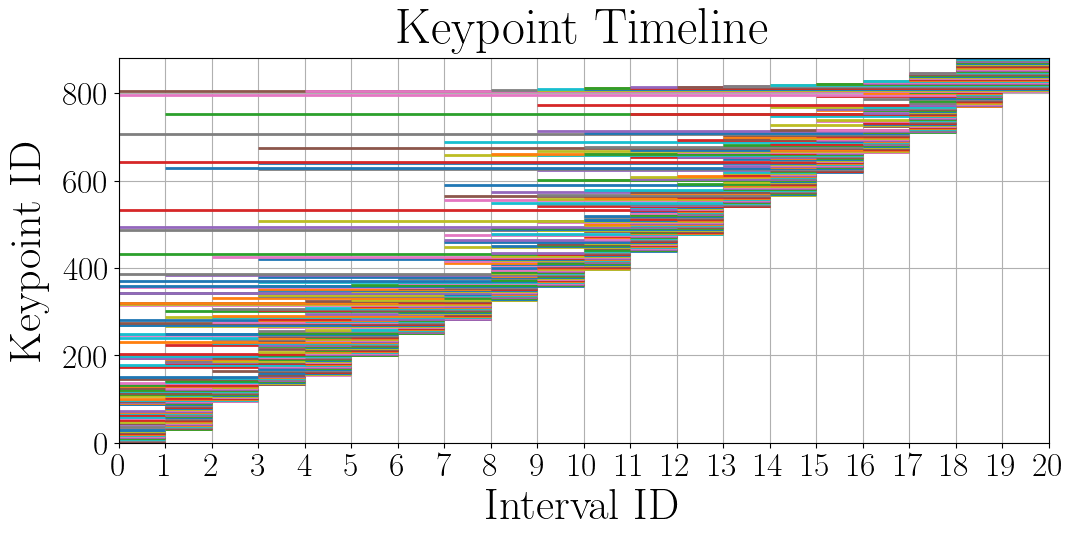

Done.


In [183]:
print("Plotting timeline...")
plot_timeline(processed_data, True)
print("Done.")

Plotting continuity...


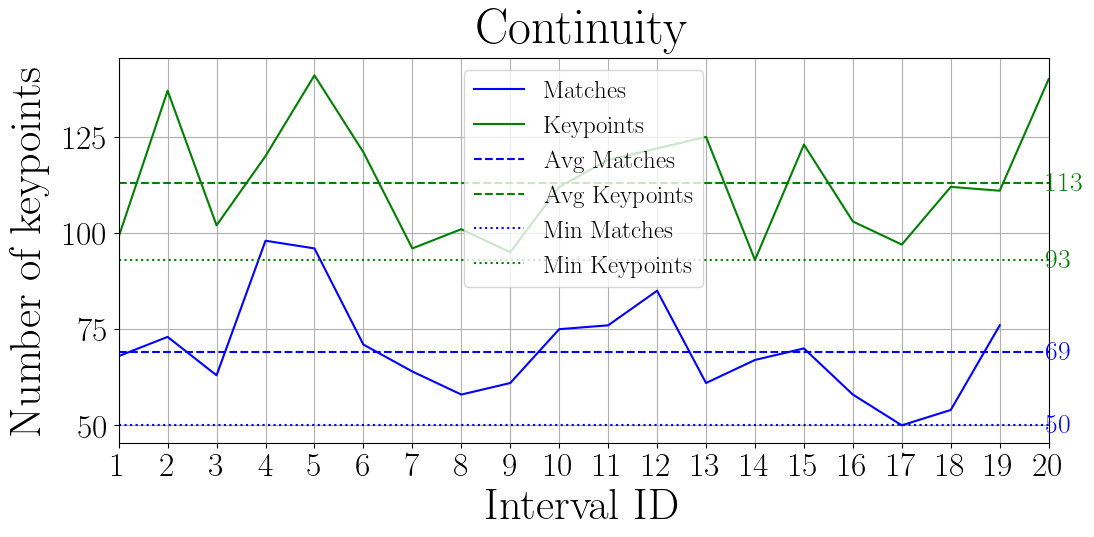

Done.


In [184]:
print("Plotting continuity...")
plot_continuity(all_matches, descriptors, True)
print("Done.")

In [185]:
def combined_plot(processed_data: np.ndarray, all_matches: np.ndarray, descriptors: np.ndarray, savefig: bool) -> None:

    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    # Create a figure with 2 rows of plots
    fig, axs = plt.subplots(nrows=2, figsize=(12, 12))

    # Timeline plot
    ax = axs[0]  # first row for the timeline
    with tqdm.tqdm(total=len(processed_data)) as pbar:
        for idx, item in enumerate(processed_data):
            pbar.update(1)
            start_interval = (item[2] - 1)
            end_interval = item[3]
            color = default_colors[idx % len(default_colors)]
            ax.hlines(idx, start_interval, end_interval, colors=color, lw=2)

    # ax.set_xlabel("Interval ID")
    ax.set_ylabel("Keypoint ID", labelpad=10)
    ax.set_title("Keypoint Timeline", pad=10)
    ax.set_xlim(0, MAX_INTERVALS)
    ax.set_ylim(0, len(processed_data))
    ax.set_xticks(np.arange(0, MAX_INTERVALS + 1, 1))
    ax.grid()

    # Continuity plot
    ax = axs[1]  # second row for continuity
    matches_numbers = [len(all_matches[i]) for i in range(len(all_matches))]
    keypoints_numbers = [len(descriptors[i]) for i in range(len(descriptors))]

    avg_matches = int(np.mean(matches_numbers))
    avg_keypoints = int(np.mean(keypoints_numbers))
    min_matches = int(np.min(matches_numbers))
    min_keypoints = int(np.min(keypoints_numbers))

    ax.plot(np.arange(1, len(matches_numbers) + 1), matches_numbers, label="Matches", color="blue")
    ax.plot(np.arange(1, len(keypoints_numbers) + 1), keypoints_numbers, label="Keypoints", color="green")

        # Plot the horizontal lines
    ax.axhline(avg_matches, label="Avg Matches", color="blue", linestyle="--")
    ax.axhline(avg_keypoints, label="Avg Keypoints", color="green", linestyle="--")
    ax.axhline(min_matches, label="Min Matches", color="blue", linestyle=":")
    ax.axhline(min_keypoints, label="Min Keypoints", color="green", linestyle=":")

    # Define a margin from the right end of the plot for the text
    margin = 1.05  # Adjust this as necessary

    # Display the values using ax.text
    ax.text(
        margin * len(matches_numbers),
        avg_matches,
        f"{avg_matches}",
        va="center", 
        ha="left",
        color="blue",
        fontsize=20,
    )
    ax.text(
        margin * len(matches_numbers),
        avg_keypoints,
        f"{avg_keypoints}",
        va="center",
        ha="left",
        color="green",
        fontsize=20,
    )
    ax.text(
        margin * len(matches_numbers),
        min_matches,
        f"{min_matches}",
        va="center",
        ha="left",
        color="blue",
        fontsize=20,
    )  # reduce font size if needed
    ax.text(
        margin * len(matches_numbers),
        min_keypoints,
        f"{min_keypoints}",
        va="center",
        ha="left",
        color="green",
        fontsize=20,
    )  # reduce font size if needed

    ax.set_xlabel("Interval ID")
    ax.set_ylabel("Number of keypoints", labelpad=10)
    ax.set_title("Continuity", pad=10)
    ax.set_xticks(np.arange(1, len(matches_numbers) + 2))
    ax.legend()
    ax.set_xlim(1, len(matches_numbers) + 1)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    if savefig:
        fig.savefig("../Results/combined_plot.pdf", bbox_inches="tight")

100%|██████████| 881/881 [00:00<00:00, 1943.50it/s]


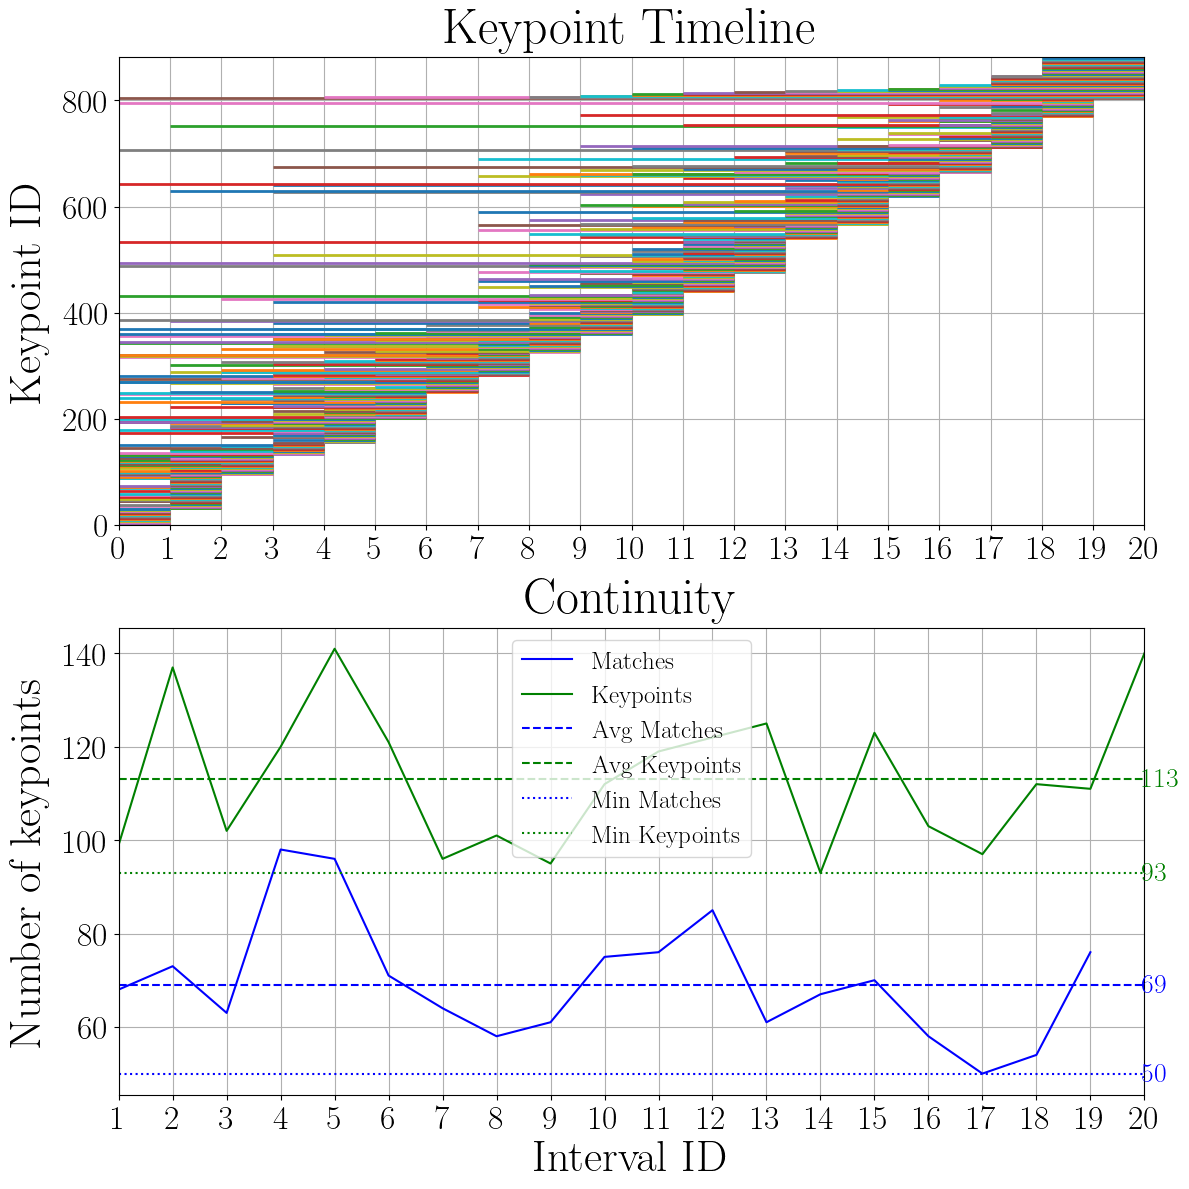

In [186]:
combined_plot(processed_data, all_matches, descriptors, True)